***
# Comparison of Methods for Addressing Unbalanced Classes and Inconsistent Image Sizes When Working with CNN's
Author: Connor Lee
***
## Project Description
The primary goal of this project was to develop my first convolutional neural network (CNN) for image classification. The learning objectives from this project were the following:
* Learn how to work with unbalanced classes
* Learn how to work with inconsistent image sizes
* Learn how to work with small training sets

The animals being compared for this project are cats, dogs, horses and zebras, the link combined dataset used for this project and the links to the original datasets from Kaggle are listed below:

* [Combined Dataset](https://my.pcloud.com/publink/show?code=kZmVMwkZtzRJUynORuuH4vbwnCzyLXXpsxiV)
* [cat and dog](https://www.kaggle.com/tongpython/cat-and-dog)
* [horse2zebra](https://www.kaggle.com/arnaud58/horse2zebra)

These datasets have images of various different sizes and image quality, they also provide an unbalanced dataset since the cat and dog dataset each have approximately 4000 training images and 1000 testing images, while the horse2zebra dataset has approximately 1000 training images and 120 testing images.

From researching methods of improving prediction results when working with unbalanced data and images of varying size I found that the following three methods were the most commonly recommended approaches:
1. Apply class weights during fitting to put more weight on under represented classes
2. Progressive resizing using transfer learning and applying class weights to address the unbalanced data
3. Image augmentation through creating transformed copies of the original training images for the under represented classes

For this project we will apply the above three methods of addressing unbalanced datasets and compare the categorical accuracy, the time to train for each model, and the prediction accuracy on a new set of 40 photos. The CNNs will be developed using keras with tensorflow, and the image augmentation for the 3rd approach will be done with using the openCV and numpy packages.

## Universal Steps
Before starting with any of the alternative methods we will import all of the libraries that will be used throughout the project.

In [1]:
### ~ Library Imports ~ ###
# General Library Imports
import os
import re
import numpy as np
import math

# Neural Network Library Imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, Adamax

# Image Reading and Augmentation Imports
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Saving and Loading Models
from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model

# Plotting Library Imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

***
## Class Weights Approach
The first approach we will look at is the method of applying class weights during fitting to put more weight on under represented classes.

### Creating the CNN
To generate the CNN the following steps were taken:
* Create a sequential CNN object
* Create the first convolutional layer with 32 filters and an input size of 256x256x3
    * The filter number and input size were identified through testing various combinations
* Create the first pooling layer
* Create four more convolutional layers, each with a pooling layer immediately after
    * The pattern and number of convolutional and pooling layers was identified through testing
* Flatten the final pooling layer to be fed into the dense layer
* Create an intermediary dense layer for analyzing output from the pooling layer
    * Dropout was added in order to combat overfitting
    * The number of nodes and dropout rate were determined through testing
* Create the final dense layer using the softmax activation function and four output nodes
    * The softmax activation function is required for multi-class classification
    * The four output nodes represent the four classes in our dataset
* Compile the classifier with the adam optimizer, the categorical cross entropy loss function and using accuracy as the metric
    * The default adam optimizer was determined to perform best through testing
    * The categorical cross entropy loss function was chosen as it was found to be the most recommended loss function for multi-class classification problems
    * The categorical_accuracy was chosen as it appears form reading the keras documentation that it is the most appropriate metric for multi-class problems

In [2]:
# Initializing the CNN
classifier = Sequential()
# Defining standard size of image to pass into CNN
img_size = 256

# Adding Convolutional and Pooling Layers
classifier.add(Conv2D(filters=32, kernel_size=[3, 3], input_shape=(img_size, img_size, 3), activation='relu'))
classifier.add(MaxPool2D(pool_size=(2,2)))
classifier.add(Conv2D(filters=32, kernel_size=[3, 3], activation='relu'))
classifier.add(MaxPool2D(pool_size=(2,2)))
classifier.add(Conv2D(filters=64, kernel_size=[3, 3], activation='relu'))
classifier.add(MaxPool2D(pool_size=(2,2)))
classifier.add(Conv2D(filters=64, kernel_size=[3, 3], activation='relu'))
classifier.add(MaxPool2D(pool_size=(2,2)))
classifier.add(Conv2D(filters=128, kernel_size=[3, 3], activation='relu'))
classifier.add(MaxPool2D(pool_size=(2,2)))

# Flattening the last pooling layer
classifier.add(Flatten())

# Adding fully connected dense layers, and combating overfitting with dropout
classifier.add(Dense(units=128, activation='relu'))
classifier.add(Dropout(rate=0.5))
classifier.add(Dense(units=4, activation='softmax'))

# Compiling the CNN and defining optimizer and loss function
classifier.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['categorical_accuracy'])

### Training the CNN
For the class weights approach we will apply weights to each class using the `class_weight` parameter for the `fit()` function. The class weights are calculated by dividing the number of training images in each class by the total number of training images and storing the values in an array. Every element of this array is then divided by the minimum value in the array in order to set the minimum weight to 1.

The training and testing data is then read in `using flow_from_directory()` method from the ImageDataGenerator object, this imports the data in a format that the CNN can use for fitting and testing. The batch sizes for the training and testing sets were determined through testing various different values and picking the best one. Finally it was found from testing various different numbers of epochs that the loss value tended to converge around 25 epochs.

Finally the `EarlyStopping` parameter and `ReduceLROnPlateau` were included in the `fit()` call help improve the model fitting by reducing overfitting, and reducing the learning rate when the changes in loss are minimal (thus allowing a more detailed gradient descent exploration of the minima). The `restore_best_weights` parameter was set to true so that the best configuration of the model would be saved rather than the most recent one.

In [3]:
### ~ Image Augmentation and Model Fitting ~ ###
# Determining class weights to handle unbalanced dataset
train_path = 'animals/training_set/'
total_train = sum([len(os.listdir(train_path+animal)) for animal in sorted(os.listdir(train_path))])
# Get total number of training pictures and counter
cls_wts = [0]*len(os.listdir(train_path))
i=0
# For loop to calculate class weights
for animal in sorted(os.listdir(train_path)):
    cls_wts[i]=total_train/len(os.listdir(train_path+animal))
    i+=1
# Dividing the class weights by the minimum class weight
cls_wts = [wt/min(cls_wts) for wt in cls_wts]
# Initializing the training and testing image generators
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

# Generating training and testing set data
training_set = train_datagen.flow_from_directory('animals/training_set',
                                                target_size=(img_size, img_size),
                                                batch_size=14,
                                                #shuffle=False,
                                                class_mode='categorical')

test_set = test_datagen.flow_from_directory('animals/test_set',
                                            target_size=(img_size, img_size),
                                            batch_size=2,
                                            #shuffle=False,
                                            class_mode='categorical')

# Fitting the CNN model
classifier.fit(training_set,
                epochs=25,
                validation_data=test_set,
                # Used to address unbalanced data
                class_weight=cls_wts,
                # Used to improve model fitting (reduce overfitting, reduce learning rate when changes are minimal)
                callbacks=[EarlyStopping(patience=5, restore_best_weights=True), ReduceLROnPlateau(patience=3)])

Found 10366 images belonging to 4 classes.
Found 2283 images belonging to 4 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 741 steps, validate for 1142 steps
Epoch 1/25
741/741 [==============================] - 322s 435ms/step - loss: 1.0346 - categorical_accuracy: 0.4911 - val_loss: 0.8928 - val_categorical_accuracy: 0.5129
Epoch 2/25
741/741 [==============================] - 319s 431ms/step - loss: 0.8296 - categorical_accuracy: 0.6189 - val_loss: 0.6928 - val_categorical_accuracy: 0.6794
Epoch 3/25
741/741 [==============================] - 321s 433ms/step - loss: 0.7351 - categorical_accuracy: 0.6704 - val_loss: 0.6599 - val_categorical_accuracy: 0.6947
Epoch 4/25
741/741 [==============================] - 324s 437ms/step - loss: 0.6721 - categorical_accuracy: 0.7132 - val_loss: 0.6108 - val_categorical_accuracy: 0.7403
Epoch 5/25
741/741 [==============================] - 328s 442ms/step - loss: 0.6306 - categorical_accuracy: 0.7370 - val_loss: 0.5505 - val

### Discussion of Results
As shown above the categorical accuracy on the validation set was found to be 0.8677 and the total time to fit was 8106 seconds.

In [24]:
# This chunk was useful during testing items can be uncommented to sumarize the CNN's tructure, save new model fits, or load the previous model fit
# Showing the format of the CNN
#classifier.summary()
#save_model(classifier, 'saved_model/cnn_256_class_weights')
#classifier = load_model('saved_model/cnn_256_class_weights')

#### Predicting on New Data
Now we will test the fitted class weights model on 40 new images (10 from each class) that the model hasn't seen before and see how it performs.

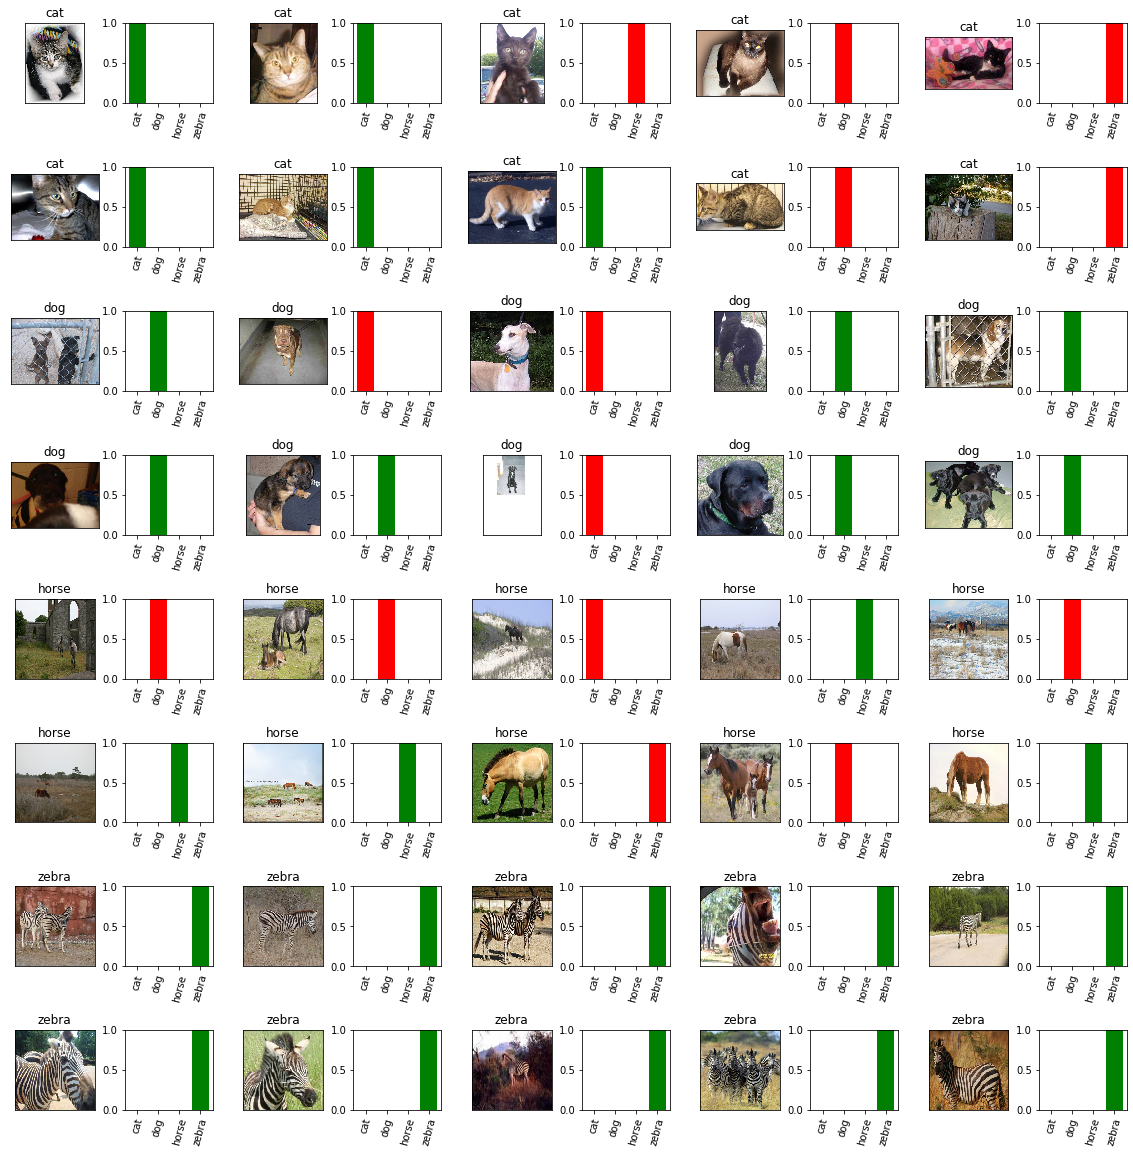

In [25]:
### ~ Running Predicitons on 10 of each class and plotting results ~ ###
path = 'animals/single_prediction/'
# Initializing variables for plot space
num_imgs = len(os.listdir(path))
cols=8
rows=math.ceil(num_imgs/(cols/2))
animal2Idx = {'cat':0, 'dog':1, 'horse':2, 'zebra':3}

# Initializing ploting space
fig, axs = plt.subplots(cols, rows, figsize=(20, 20))
plt.subplots_adjust(hspace=0.8, wspace=0.3)
axs = axs.ravel()
# For loop to plot predictions
i = 0
for image in sorted(os.listdir(path)):
    # Setting correct prediction bars as green and incorrect as red
    cols = ['red', 'red', 'red', 'red']
    cols[animal2Idx[image.split("_")[0]]]='green'
    # Read in and process image
    cur_img = cv2.imread(path+image)
    cur_img = cv2.resize(cur_img, (img_size, img_size))
    cur_img = np.reshape(cur_img, (1,img_size,img_size,3))
    # Plot image
    axs[i].imshow(plt.imread(path+image))
    axs[i].set_title(image.split("_")[0])
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    # Plot prediction probabilities
    axs[i+1].bar([0,1,2,3], classifier.predict(cur_img)[0], color=cols)
    axs[i+1].set_xticks(np.arange(len(training_set.class_indices.keys())))
    axs[i+1].set_xticklabels(list(training_set.class_indices.keys()), rotation=75)
    axs[i+1].set_ylim([0,1])
    i+=2

As shown above the model predicted 65% of the 40 new images correctly, with the following prediction percentages per class:
* Cats: 50%
* Dogs: 70%
* Horses: 40%
* Zebras: 100%

***
## Progressive Resizing Approach
The second approach we will apply is the method of progressive resizing through transfer learning. The idea behind this method is to fit several simple CNN's to the same data with progressively growing input sizes such that the different layers are trained to capture different levels of detail in the image. The transfer learning approach is implemented by saving the weights from each convolution and pooling layers after each model fit, and using those as the first layers of the next model. From this the model gets trained on various input sizes, and retains the information from the other input sizes, this allows different layers to recognise different levels of detail (ex. the first 3 layers could recognize details present in smaller regions, while the last 3 layers might recognize bigger picture details).

For this model three model fits will be implemented, the first an input size of 64x64x3, the second for an input size of 128x128x3, and the last for an input size of 256x256x3. Three fits were used as two fits underperformed the more complex model significantly, and four fits was deemed computationally infeasible due to the expected duration of the fourth fit.

### Creating the CNN
Many of the steps and concepts for creating the CNN's for each fit for the progressive resizing approach were the same as in the class weights approach, as a result only the parts that are novel to this method will be discussed in detail. All of the previously discussed information, from number of layers, through batch size, and number of epochs were determined through testing various different values and taking the best performing value. 
#### First Model Fit
The first model fit was done with an input size of 64.

In [29]:
## First Layer
# Initializing the CNN
first_model = Sequential()
# Defining standard size of image to pass into CNN
img_size = 64
num_epochs = 25
train_batch_size = 14

# Adding Convolutional and Pooling Layers
first_model.add(Conv2D(filters=64, kernel_size=[3, 3], input_shape=(img_size, img_size, 3), activation='relu', padding='same')) # NOTE: Tensorflow input shape is (img size, img size, # chanels) while theano is (# chanels, img size, img size)
first_model.add(Conv2D(filters=64, kernel_size=[3, 3], input_shape=(img_size, img_size, 3), activation='relu', padding='same'))
first_model.add(MaxPool2D(pool_size=(2,2)))

# Flattening the last pooling layer
first_model.add(Flatten())

# Adding fully connected dense layers, and combating overfitting with dropout
first_model.add(Dense(units=128, activation='relu'))
first_model.add(Dropout(rate=0.5))
first_model.add(Dense(units=4, activation='softmax'))

# Compiling the CNN and defining optimizer and loss function
first_model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [30]:
### ~ Image Augmentation and Model Fitting ~ ###
# Determining class weights to handle unbalanced dataset
train_path = 'animals/training_set/'
total_train = sum([len(os.listdir(train_path+animal)) for animal in sorted(os.listdir(train_path))])
# Get total number of training pictures and counter
cls_wts = [0]*len(os.listdir(train_path))
i=0
# For loop to calculate class weights
for animal in sorted(os.listdir(train_path)):
    cls_wts[i]=total_train/len(os.listdir(train_path+animal))
    i+=1
# Dividing the class weights by the minimum class weight
cls_wts = [wt/min(cls_wts) for wt in cls_wts]

# Initializing the training and testing image generators
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

# Generating training and testing set data
training_set = train_datagen.flow_from_directory('animals/training_set',
                                                target_size=(img_size, img_size),
                                                batch_size=train_batch_size,
                                                #shuffle=False,
                                                class_mode='categorical')

test_set = test_datagen.flow_from_directory('animals/test_set',
                                            target_size=(img_size, img_size),
                                            batch_size=2,
                                            #shuffle=False,
                                            class_mode='categorical')

# Fitting the CNN model
first_model.fit(training_set,
                epochs=num_epochs,
                validation_data=test_set,
                # Used to address unbalanced data
                class_weight=cls_wts,
                # Used to improve model fitting (reduce overfitting, reduce learning rate when changes are minimal)
                callbacks=[EarlyStopping(patience=5, restore_best_weights=True), ReduceLROnPlateau(patience=3)])

Found 10366 images belonging to 4 classes.
Found 2283 images belonging to 4 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 741 steps, validate for 1142 steps
Epoch 1/25
741/741 [==============================] - 133s 179ms/step - loss: 1.0561 - categorical_accuracy: 0.5000 - val_loss: 0.8627 - val_categorical_accuracy: 0.5686
Epoch 2/25
741/741 [==============================] - 130s 175ms/step - loss: 0.8895 - categorical_accuracy: 0.5861 - val_loss: 0.8561 - val_categorical_accuracy: 0.5935
Epoch 3/25
741/741 [==============================] - 132s 178ms/step - loss: 0.8453 - categorical_accuracy: 0.6189 - val_loss: 0.9676 - val_categorical_accuracy: 0.5953
Epoch 4/25
741/741 [==============================] - 135s 183ms/step - loss: 0.8031 - categorical_accuracy: 0.6447 - val_loss: 0.7509 - val_categorical_accuracy: 0.6430
Epoch 5/25
741/741 [==============================] - 131s 176ms/step - loss: 0.7757 - categorical_accuracy: 0.6547 - val_loss: 0.7539 - val

In [ ]:
# This chunk is used to implement the transfer learning, it also allows for model saving during the fitting process in the event that there is an issue and the fitting needs to restart
# Saving Current Model
save_model(first_model, 'saved_model/cnn_prog_resize_64_start64')
# Loading Previous Model
last_model = load_model('saved_model/cnn_prog_resize_64_start64')
# Checking Configuration (used for testing)
#last_model.summary()

#### Second Model Fit
The second model fit was done with an input size of twice the first model fit (128). The first step of building the CNN for the second model fit is to create the convolutional and pooling layers for the new input size. The next step is to extract the convolutional and pooling layers from the previous fit, the weights for these layers are set so that they can't be changed by setting the `trainable` parameter to `False`. The static layers from the previous fit can then be added to the new model. This will allow the model to take into account the previous weights from the smaller input parameter layers, while still allowing it to train new weights for the larger input parameter layers.

In [32]:
next_model = Sequential()

img_size = img_size*2

# Adding Convolutional and Pooling Layers
next_model.add(Conv2D(filters=64, kernel_size=[3, 3], input_shape=(img_size, img_size, 3), activation='relu', padding='same')) # NOTE: Tensorflow input shape is (img size, img size, # chanels) while theano is (# chanels, img size, img size)
next_model.add(Conv2D(filters=64, kernel_size=[3, 3], input_shape=(img_size, img_size, 3), activation='relu', padding='same'))
next_model.add(MaxPool2D(pool_size=(2,2)))

for layer in last_model.layers[1:3]:
    layer.trainable = False
    next_model.add(layer)
    
# Flattening the last pooling layer
next_model.add(Flatten())

# Adding fully connected dense layers, and combating overfitting with dropout
next_model.add(Dense(units=128, activation='relu'))
next_model.add(Dropout(rate=0.5))
next_model.add(Dense(units=4, activation='softmax'))

# Compiling the CNN and defining optimizer and loss function
next_model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [33]:
### ~ Image Augmentation and Model Fitting ~ ###
# Initializing the training and testing image generators
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

# Generating training and testing set data
training_set = train_datagen.flow_from_directory('animals/training_set',
                                                target_size=(img_size, img_size),
                                                batch_size=train_batch_size,
                                                #shuffle=False,
                                                class_mode='categorical')

test_set = test_datagen.flow_from_directory('animals/test_set',
                                            target_size=(img_size, img_size),
                                            batch_size=2,
                                            #shuffle=False,
                                            class_mode='categorical')

# Fitting the CNN model
next_model.fit(training_set,
                epochs=num_epochs,
                validation_data=test_set,
                # Used to address unbalanced data
                class_weight=cls_wts,
                # Used to improve model fitting (reduce overfitting, reduce learning rate when changes are minimal)
                callbacks=[EarlyStopping(patience=5, restore_best_weights=True), ReduceLROnPlateau(patience=3)])

Found 10366 images belonging to 4 classes.
Found 2283 images belonging to 4 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 741 steps, validate for 1142 steps
Epoch 1/25
741/741 [==============================] - 375s 506ms/step - loss: 1.0094 - categorical_accuracy: 0.5241 - val_loss: 0.8667 - val_categorical_accuracy: 0.6027
Epoch 2/25
741/741 [==============================] - 374s 505ms/step - loss: 0.8483 - categorical_accuracy: 0.6115 - val_loss: 1.0056 - val_categorical_accuracy: 0.5532
Epoch 3/25
741/741 [==============================] - 398s 537ms/step - loss: 0.7914 - categorical_accuracy: 0.6366 - val_loss: 0.8933 - val_categorical_accuracy: 0.6080
Epoch 4/25
741/741 [==============================] - 381s 514ms/step - loss: 0.7508 - categorical_accuracy: 0.6587 - val_loss: 0.9359 - val_categorical_accuracy: 0.6045
Epoch 5/25
741/741 [==============================] - 381s 514ms/step - loss: 0.6853 - categorical_accuracy: 0.6925 - val_loss: 0.7416 - val

In [ ]:
# Saving Current Model
save_model(next_model, 'saved_model/cnn_prog_resize_128_start64')
# Loading Previous Model
last_model = load_model('saved_model/cnn_prog_resize_128_start64')
# Checking Configuration (Used for testing)
#last_model.summary()

#### Third Model Fit
The third model fit was done with an input size of twice the second model fit (256). The same procedure was followed for the third model fit as for the second model fit with the only notable difference being that the previously fit layers from the first and second model fit were saved and added to the new model.

In [36]:
next_model = Sequential()

img_size = img_size*2

# Adding Convolutional and Pooling Layers
next_model.add(Conv2D(filters=64, kernel_size=[3, 3], input_shape=(img_size, img_size, 3), activation='relu', padding='same')) # NOTE: Tensorflow input shape is (img size, img size, # chanels) while theano is (# chanels, img size, img size)
next_model.add(Conv2D(filters=64, kernel_size=[3, 3], input_shape=(img_size, img_size, 3), activation='relu', padding='same'))
next_model.add(MaxPool2D(pool_size=(2,2)))

for layer in last_model.layers[1:5]:
    layer.trainable = False
    next_model.add(layer)
    
# Flattening the last pooling layer
next_model.add(Flatten())

# Adding fully connected dense layers, and combating overfitting with dropout
next_model.add(Dense(units=128, activation='relu'))
next_model.add(Dropout(rate=0.5))
next_model.add(Dense(units=4, activation='softmax'))

# Compiling the CNN and defining optimizer and loss function
next_model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [37]:
### ~ Image Augmentation and Model Fitting ~ ###
# Initializing the training and testing image generators
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

# Generating training and testing set data
training_set = train_datagen.flow_from_directory('animals/training_set',
                                                target_size=(img_size, img_size),
                                                batch_size=train_batch_size,
                                                #shuffle=False,
                                                class_mode='categorical')

test_set = test_datagen.flow_from_directory('animals/test_set',
                                            target_size=(img_size, img_size),
                                            batch_size=2,
                                            #shuffle=False,
                                            class_mode='categorical')

# Fitting the CNN model
next_model.fit(training_set,
                epochs=num_epochs,
                validation_data=test_set,
                # Used to address unbalanced data
                class_weight=cls_wts,
                # Used to improve model fitting (reduce overfitting, reduce learning rate when changes are minimal)
                callbacks=[EarlyStopping(patience=5, restore_best_weights=True), ReduceLROnPlateau(patience=3)])

Found 10366 images belonging to 4 classes.
Found 2283 images belonging to 4 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 741 steps, validate for 1142 steps
Epoch 1/25
741/741 [==============================] - 1479s 2s/step - loss: 1.0198 - categorical_accuracy: 0.5096 - val_loss: 0.8132 - val_categorical_accuracy: 0.6364
Epoch 2/25
741/741 [==============================] - 1476s 2s/step - loss: 0.7959 - categorical_accuracy: 0.6470 - val_loss: 0.6765 - val_categorical_accuracy: 0.6746
Epoch 3/25
741/741 [==============================] - 1475s 2s/step - loss: 0.7436 - categorical_accuracy: 0.6634 - val_loss: 0.7137 - val_categorical_accuracy: 0.6908
Epoch 4/25
741/741 [==============================] - 1480s 2s/step - loss: 0.7175 - categorical_accuracy: 0.6801 - val_loss: 0.6848 - val_categorical_accuracy: 0.6693
Epoch 5/25
741/741 [==============================] - 1481s 2s/step - loss: 0.6711 - categorical_accuracy: 0.7029 - val_loss: 0.6722 - val_categoric

### Discussion of Results
As shown above the categorical accuracy on the validation set was found to be 0.7740 and the total time to fit (cumulative from all three fits) was 42876 seconds.

In [ ]:
# This chunk was useful during testing items can be uncommented to sumarize the CNN's tructure, save new model fits, or load the previous model fit and code required to load the relevant data
# Saving Current Model
#save_model(next_model, 'saved_model/cnn_prog_resize_256_start64')
# Loading Previous Model
#next_model = load_model('saved_model/cnn_prog_resize_256_start64')
# Checking Configuration
#next_model.summary()

# Uncomment to load required data for the final saved model
#img_size = 64*2*2
#train_batch_size = 14
#train_datagen = ImageDataGenerator(
#        rescale=1./255,
#        shear_range=0.25,
#        zoom_range=0.25,
#        horizontal_flip=True)
#training_set = train_datagen.flow_from_directory('animals/training_set',
#                                                target_size=(img_size, img_size),
#                                                batch_size=train_batch_size,
#                                                class_mode='categorical')

#### Predicting on New Data
Now we will test the fitted progressive resizing model on 40 new images (10 from each class) that the model hasn't seen before and see how it performs.

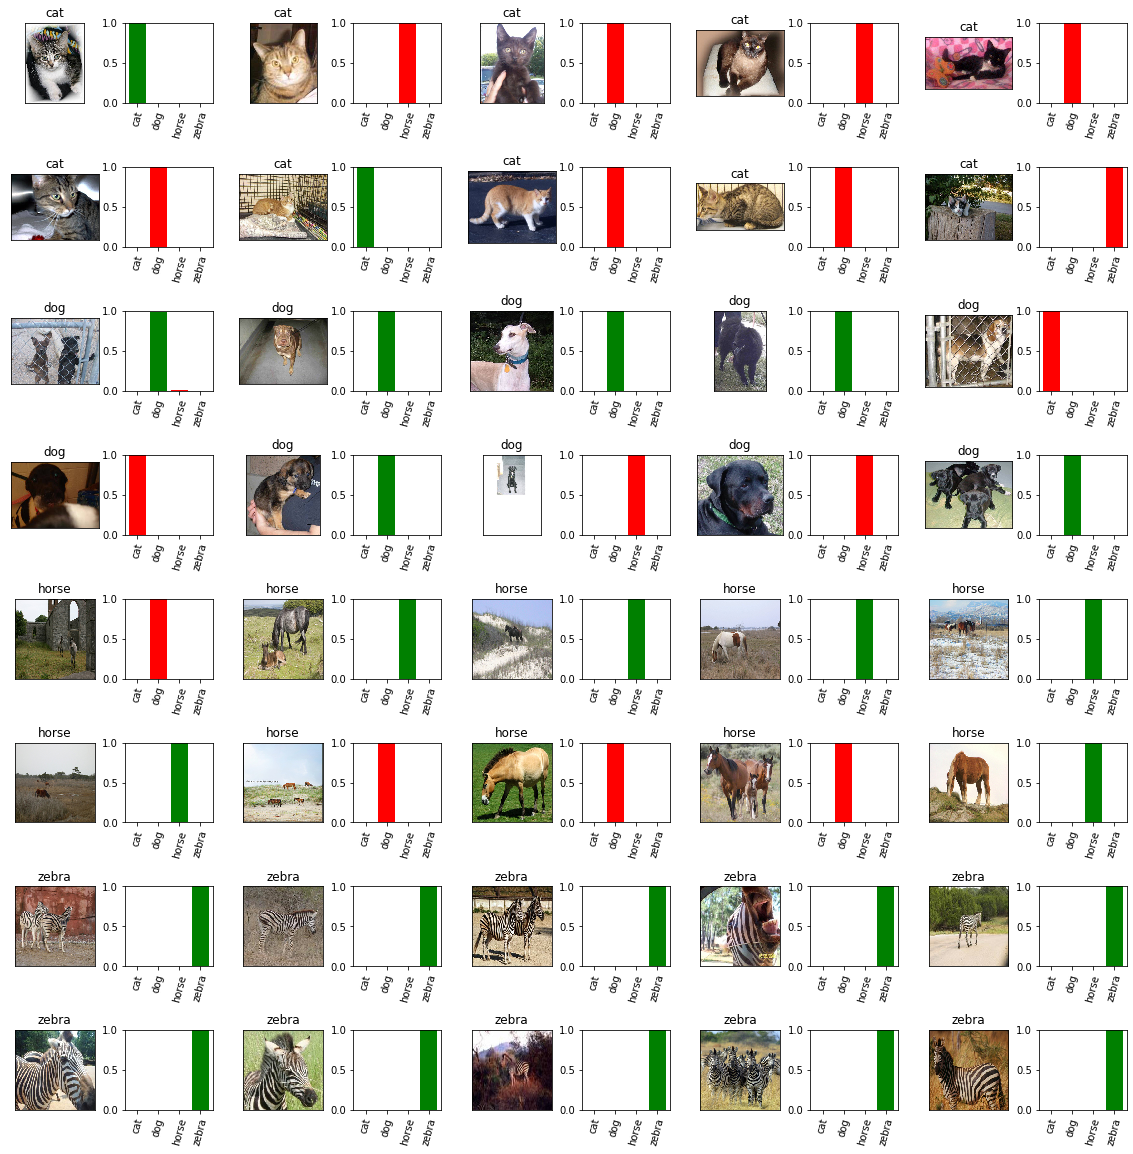

In [39]:
### ~ Running Predicitons on 10 of each class and plotting results ~ ###
path = 'animals/single_prediction/'
# Initializing variables for plot space
num_imgs = len(os.listdir(path))
cols=8
rows=math.ceil(num_imgs/(cols/2))
animal2Idx = {'cat':0, 'dog':1, 'horse':2, 'zebra':3}

# Initializing ploting space
fig, axs = plt.subplots(cols, rows, figsize=(20, 20))
plt.subplots_adjust(hspace=0.8, wspace=0.3)
axs = axs.ravel()
# For loop to plot predictions
i = 0
for image in sorted(os.listdir(path)):
    # Setting correct prediction bars as green and incorrect as red
    cols = ['red', 'red', 'red', 'red']
    cols[animal2Idx[image.split("_")[0]]]='green'
    # Read in and process image
    cur_img = cv2.imread(path+image)
    cur_img = cv2.resize(cur_img, (img_size, img_size))
    cur_img = np.reshape(cur_img, (1,img_size,img_size,3))
    # Plot image
    axs[i].imshow(plt.imread(path+image))
    axs[i].set_title(image.split("_")[0])
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    # Plot prediction probabilities
    axs[i+1].bar([0,1,2,3], next_model.predict(cur_img)[0], color=cols)
    axs[i+1].set_xticks(np.arange(len(training_set.class_indices.keys())))
    axs[i+1].set_xticklabels(list(training_set.class_indices.keys()), rotation=75)
    axs[i+1].set_ylim([0,1])
    i+=2

As shown above the model predicted 60% of the 40 new images correctly.
* Cats: 20%
* Dogs: 60%
* Horses: 60%
* Zebras: 100%

***
## Image Augmentation Approach
The final approach we will consider is the image augmentation approach where we will balance the classes by creating transformed versions of the images in the classes with fewer images in them, so that the total number of images per class in both the training and testing sets will be approximately the same. Since the horse and zebra training sets have approximately 1/4 of the images that the cats and dogs datasets have we will generate 3 transformed versions of each image in the horse and zebra training sets to even out the classes. The transformations will consist of various combinations of mirroring the image across the axis, and rotating the image.

In [12]:
# Image Augmentation for Horse Training Set
img_size=256
path = 'animals/training_set_aug/horse/'

# Initializing variables for plot space
num_imgs = len(os.listdir(path))

# Iterator for unique file naming
i = 0
# For loop to plot predictions
for image in sorted(os.listdir(path)):
    # Reading in Images to Transform
    gen_img = cv2.imread(path+image)
    gen_img = cv2.resize(gen_img, (img_size, img_size))
    
    # Transforming image data
    gen_img90 = np.rot90(gen_img).tolist()
    gen_img_mirror = cv2.flip(gen_img, +1)
    gen_img_mirror180 = np.rot90(cv2.flip(gen_img, +1),2).tolist()
    
    # Reshaping Images data
    gen_img90 = np.reshape(gen_img90, (img_size,img_size,3))
    gen_img_mirror = np.reshape(gen_img_mirror, (img_size,img_size,3))
    gen_img_mirror180 = np.reshape(gen_img_mirror180, (img_size,img_size,3))
    
    # Generating transformed images from image data
    cv2.imwrite(path+'/horse_90'+str(i)+".jpg",gen_img90)
    cv2.imwrite(path+'/horse_mirror'+str(i)+".jpg",gen_img_mirror)
    cv2.imwrite(path+'/horse_mirror180'+str(i)+".jpg",gen_img_mirror180)
    # Incremment iterator
    i+=1

In [13]:
# Image Augmentation for Zebra Training Set
path = 'animals/training_set_aug/zebra/'

# Initializing variables for plot space
num_imgs = len(os.listdir(path))

# Iterator for unique file naming
i = 0
# For loop to plot predictions
for image in sorted(os.listdir(path)):
    # Reading in Images to Transform
    gen_img = cv2.imread(path+image)
    gen_img = cv2.resize(gen_img, (img_size, img_size))
    
    # Transforming image data
    gen_img90 = np.rot90(gen_img).tolist()
    gen_img_mirror = cv2.flip(gen_img, +1)
    gen_img_mirror180 = np.rot90(cv2.flip(gen_img, +1),2).tolist()
    
    # Reshaping Images data
    gen_img90 = np.reshape(gen_img90, (img_size,img_size,3))
    gen_img_mirror = np.reshape(gen_img_mirror, (img_size,img_size,3))
    gen_img_mirror180 = np.reshape(gen_img_mirror180, (img_size,img_size,3))
    
    # Generating transformed images from image data
    cv2.imwrite(path+'/zebra_90'+str(i)+".jpg",gen_img90)
    cv2.imwrite(path+'/zebra_mirror'+str(i)+".jpg",gen_img_mirror)
    cv2.imwrite(path+'/zebra_mirror180'+str(i)+".jpg",gen_img_mirror180)
    # Incremment iterator
    i+=1

Since the horse and zebra training sets have approximately 1/8 of the images that the cats and dogs datasets have we will generate 7 transformed versions of each image in the horse and zebra training sets to even out the classes.

In [14]:
# Image Augmentation for Horse Testing Set
path = 'animals/test_set_aug/horse/'

# Initializing variables for plot space
num_imgs = len(os.listdir(path))

# For loop to plot predictions
i = 0
for image in sorted(os.listdir(path)):
    # Generating rotated image
    gen_img = cv2.imread(path+image)
    gen_img = cv2.resize(gen_img, (img_size, img_size))
    # Rotations just for training set
    gen_img90 = np.rot90(gen_img).tolist()
    gen_img_mirror = cv2.flip(gen_img, +1)
    gen_img_mirror180 = np.rot90(cv2.flip(gen_img, +1),2).tolist()
    # Rotations for testing set
    gen_img180 = np.rot90(gen_img,2).tolist()
    gen_img270 = np.rot90(gen_img,3).tolist()
    gen_img_mirror90 = np.rot90(cv2.flip(gen_img, +1)).tolist()
    gen_img_mirror270 = np.rot90(cv2.flip(gen_img, +1),3).tolist()
    
    # Reshaping Images just for training set
    gen_img90 = np.reshape(gen_img90, (img_size,img_size,3))
    gen_img_mirror = np.reshape(gen_img_mirror, (img_size,img_size,3))
    gen_img_mirror180 = np.reshape(gen_img_mirror180, (img_size,img_size,3))
    
    # Reshaping Images for testing set
    gen_img180 = np.reshape(gen_img180, (img_size,img_size,3))
    gen_img270 = np.reshape(gen_img270, (img_size,img_size,3))
    gen_img_mirror90 = np.reshape(gen_img_mirror90, (img_size,img_size,3))
    gen_img_mirror270 = np.reshape(gen_img_mirror270, (img_size,img_size,3))
    
    # Writing transfomed images just for training set
    cv2.imwrite(path+'/horse_90'+str(i)+".jpg",gen_img90)
    cv2.imwrite(path+'/horse_mirror'+str(i)+".jpg",gen_img_mirror)
    cv2.imwrite(path+'/horse_mirror180'+str(i)+".jpg",gen_img_mirror180)
    
    # Writing transfomed images just for training set
    cv2.imwrite(path+'/horse_180'+str(i)+".jpg",gen_img180)
    cv2.imwrite(path+'/horse_270'+str(i)+".jpg",gen_img270)
    cv2.imwrite(path+'/horse_mirror90'+str(i)+".jpg",gen_img_mirror90)
    cv2.imwrite(path+'/horse_mirror270'+str(i)+".jpg",gen_img_mirror270)
    # Incremment counter
    i+=1

In [15]:
# Image Augmentation for Zebra Testing Set
path = 'animals/test_set_aug/zebra/'

# Initializing variables for plot space
num_imgs = len(os.listdir(path))

# For loop to plot predictions
i = 0
for image in sorted(os.listdir(path)):
    # Generating rotated image
    gen_img = cv2.imread(path+image)
    gen_img = cv2.resize(gen_img, (img_size, img_size))
    # Rotations just for training set
    gen_img90 = np.rot90(gen_img).tolist()
    gen_img_mirror = cv2.flip(gen_img, +1)
    gen_img_mirror180 = np.rot90(cv2.flip(gen_img, +1),2).tolist()
    # Rotations for testing set
    gen_img180 = np.rot90(gen_img,2).tolist()
    gen_img270 = np.rot90(gen_img,3).tolist()
    gen_img_mirror90 = np.rot90(cv2.flip(gen_img, +1)).tolist()
    gen_img_mirror270 = np.rot90(cv2.flip(gen_img, +1),3).tolist()
    
    # Reshaping Images just for training set
    gen_img90 = np.reshape(gen_img90, (img_size,img_size,3))
    gen_img_mirror = np.reshape(gen_img_mirror, (img_size,img_size,3))
    gen_img_mirror180 = np.reshape(gen_img_mirror180, (img_size,img_size,3))
    
    # Reshaping Images for testing set
    gen_img180 = np.reshape(gen_img180, (img_size,img_size,3))
    gen_img270 = np.reshape(gen_img270, (img_size,img_size,3))
    gen_img_mirror90 = np.reshape(gen_img_mirror90, (img_size,img_size,3))
    gen_img_mirror270 = np.reshape(gen_img_mirror270, (img_size,img_size,3))
    
    # Writing transfomed images just for training set
    cv2.imwrite(path+'/zebra_90'+str(i)+".jpg",gen_img90)
    cv2.imwrite(path+'/zebra_mirror'+str(i)+".jpg",gen_img_mirror)
    cv2.imwrite(path+'/zebra_mirror180'+str(i)+".jpg",gen_img_mirror180)
    
    # Writing transfomed images just for training set
    cv2.imwrite(path+'/zebra_180'+str(i)+".jpg",gen_img180)
    cv2.imwrite(path+'/zebra_270'+str(i)+".jpg",gen_img270)
    cv2.imwrite(path+'/zebra_mirror90'+str(i)+".jpg",gen_img_mirror90)
    cv2.imwrite(path+'/zebra_mirror270'+str(i)+".jpg",gen_img_mirror270)
    # Incremment counter
    i+=1

### Creating the CNN
Since the model from this section is intended to balance out the classes, similar to the class weights method but in a different way, the model configuration for the class weights model was implemented here as it already went through significant amounts of testing to find the best configuration. The main difference will be that since we have balanced the dataset by duplicating and transforming images we no longer need the class weights argument in the call to the `fit()` function.

In [16]:
# Initializing the CNN
classifier = Sequential()
# Defining standard size of image to pass into CNN
img_size = 256

# Adding Convolutional and Pooling Layers
classifier.add(Conv2D(filters=32, kernel_size=[3, 3], input_shape=(img_size, img_size, 3), activation='relu'))
classifier.add(MaxPool2D(pool_size=(2,2)))
classifier.add(Conv2D(filters=32, kernel_size=[3, 3], activation='relu'))
classifier.add(MaxPool2D(pool_size=(2,2)))
classifier.add(Conv2D(filters=64, kernel_size=[3, 3], activation='relu'))
classifier.add(MaxPool2D(pool_size=(2,2)))
classifier.add(Conv2D(filters=64, kernel_size=[3, 3], activation='relu'))
classifier.add(MaxPool2D(pool_size=(2,2)))
classifier.add(Conv2D(filters=128, kernel_size=[3, 3], activation='relu'))
classifier.add(MaxPool2D(pool_size=(2,2)))

# Flattening the last pooling layer
classifier.add(Flatten())

# Adding fully connected dense layers, and combating overfitting with dropout
classifier.add(Dense(units=128, activation='relu'))
classifier.add(Dropout(rate=0.5))
classifier.add(Dense(units=4, activation='softmax'))

# Compiling the CNN and defining optimizer and loss function
classifier.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [17]:
### ~ Model Fitting ~ ###
# Initializing the training and testing image generators
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

# Generating training and testing set data
training_set = train_datagen.flow_from_directory('animals/training_set_aug',
                                                target_size=(img_size, img_size),
                                                batch_size=14,
                                                #shuffle=False,
                                                class_mode='categorical')

test_set = test_datagen.flow_from_directory('animals/test_set_aug',
                                            target_size=(img_size, img_size),
                                            batch_size=2,
                                            #shuffle=False,
                                            class_mode='categorical')

# Used to address unbalanced data
# class_weight=cls_wts,

# Fitting the CNN model
classifier.fit(training_set,
                epochs=25,
                validation_data=test_set,
                # Used to improve model fitting (reduce overfitting, reduce learning rate when changes are minimal)
                callbacks=[EarlyStopping(patience=5, restore_best_weights=True), ReduceLROnPlateau(patience=3)])

Found 17509 images belonging to 4 classes.
Found 4103 images belonging to 4 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1251 steps, validate for 2052 steps
Epoch 1/25
1251/1251 [==============================] - 528s 422ms/step - loss: 0.9152 - categorical_accuracy: 0.5782 - val_loss: 0.7488 - val_categorical_accuracy: 0.6734
Epoch 2/25
1251/1251 [==============================] - 554s 443ms/step - loss: 0.7269 - categorical_accuracy: 0.6810 - val_loss: 0.9087 - val_categorical_accuracy: 0.6135
Epoch 3/25
1251/1251 [==============================] - 571s 456ms/step - loss: 0.6489 - categorical_accuracy: 0.7241 - val_loss: 0.5739 - val_categorical_accuracy: 0.7650
Epoch 4/25
1251/1251 [==============================] - 579s 462ms/step - loss: 0.5728 - categorical_accuracy: 0.7597 - val_loss: 0.4995 - val_categorical_accuracy: 0.7850
Epoch 5/25
1251/1251 [==============================] - 560s 448ms/step - loss: 0.5181 - categorical_accuracy: 0.7865 - val_loss: 0

### Discussion of Results
As shown above the categorical accuracy on the validation set was found to be 0.9106 and the total time to fit was 14143.

In [42]:
# This chunk was useful during testing items can be uncommented to sumarize the CNN's tructure, save new model fits, or load the previous model fit and code required to load the relevant data
# Saving Current Model
#save_model(classifier, 'saved_model/cnn_img_aug')
# Loading Previous Model
#classifier = load_model('saved_model/cnn_img_aug')
# Checking Configuration
#classifier.summary()

# Uncomment to load required data for the final saved model
#img_size = 64*2*2
#train_batch_size = 14
#train_datagen = ImageDataGenerator(
#        rescale=1./255,
#        shear_range=0.25,
#        zoom_range=0.25,
#        horizontal_flip=True)
#training_set = train_datagen.flow_from_directory('animals/training_set_aug',
#                                                target_size=(img_size, img_size),
#                                                batch_size=train_batch_size,
#                                                class_mode='categorical')

#### Predicting on New Data
Now we will test the fitted progressive resizing model on 40 new images (10 from each class) that the model hasn't seen before and see how it performs.

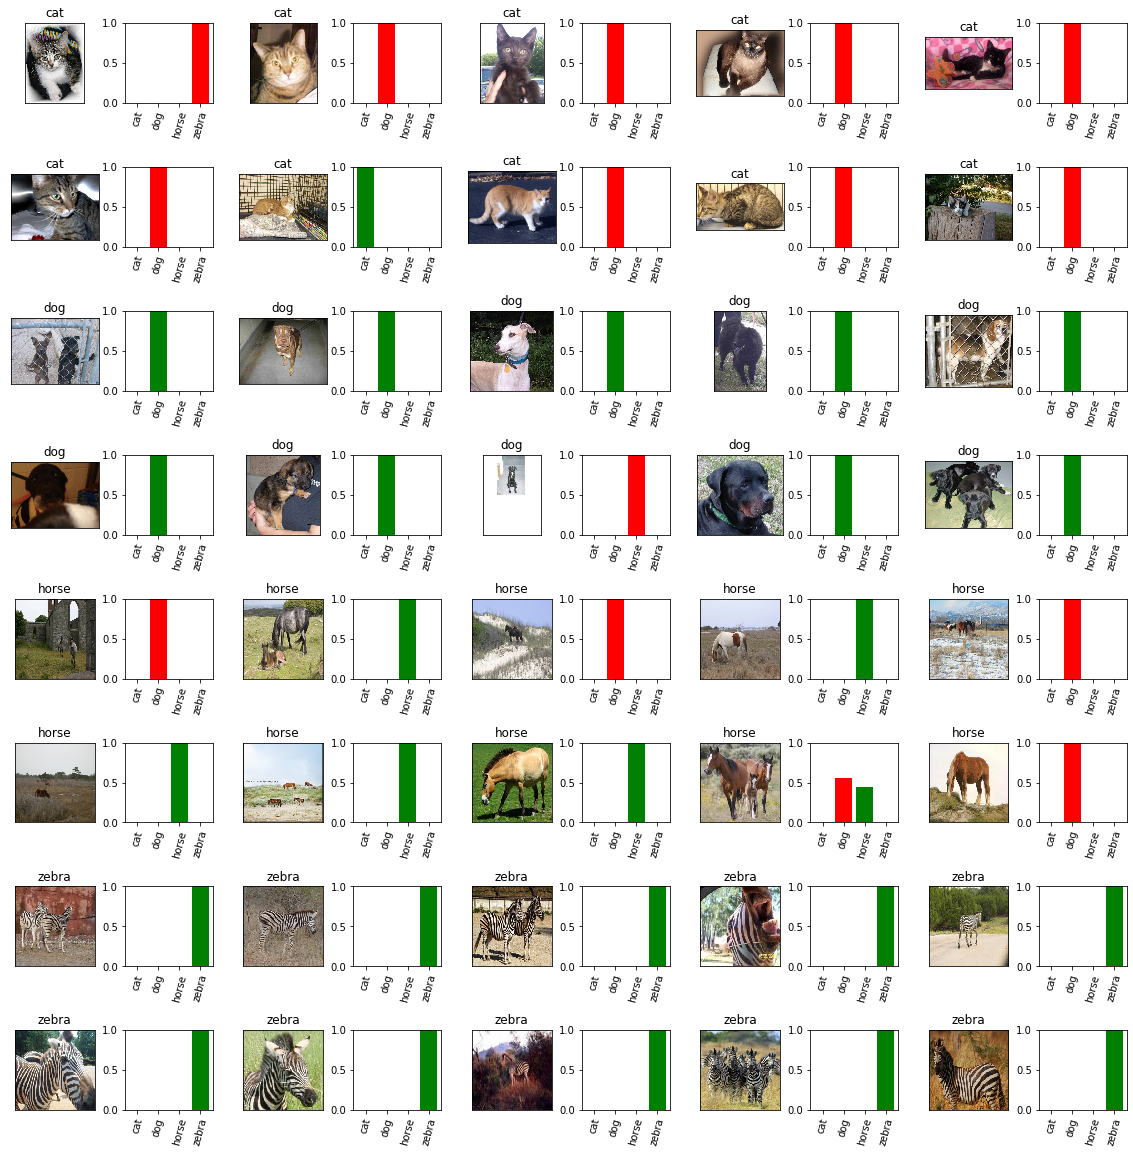

In [23]:
### ~ Running Predicitons on 10 of each class and plotting results ~ ###
path = 'animals/single_prediction/'
# Initializing variables for plot space
num_imgs = len(os.listdir(path))
cols=8
rows=math.ceil(num_imgs/(cols/2))
animal2Idx = {'cat':0, 'dog':1, 'horse':2, 'zebra':3}

# Initializing ploting space
fig, axs = plt.subplots(cols, rows, figsize=(20, 20))
plt.subplots_adjust(hspace=0.8, wspace=0.3)
axs = axs.ravel()
# For loop to plot predictions
i = 0
for image in sorted(os.listdir(path)):
    # Setting correct prediction bars as green and incorrect as red
    cols = ['red', 'red', 'red', 'red']
    cols[animal2Idx[image.split("_")[0]]]='green'
    # Read in and process image
    cur_img = cv2.imread(path+image)
    cur_img = cv2.resize(cur_img, (img_size, img_size))
    cur_img = np.reshape(cur_img, (1,img_size,img_size,3))
    # Plot image
    axs[i].imshow(plt.imread(path+image))
    axs[i].set_title(image.split("_")[0])
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    # Plot prediction probabilities
    axs[i+1].bar([0,1,2,3], classifier.predict(cur_img)[0], color=cols)
    axs[i+1].set_xticks(np.arange(len(training_set.class_indices.keys())))
    axs[i+1].set_xticklabels(list(training_set.class_indices.keys()), rotation=75)
    axs[i+1].set_ylim([0,1])
    i+=2

As shown above the model predicted 62.5% of the 40 new images correctly.
* Cats: 10%
* Dogs: 90%
* Horses: 50%
* Zebras: 100%

## Conclusion
The following three methods were implemented in an effort to see which provides the best tradeoff between categorical accuracy, time to fit, and prediction accuracy on new images:
1. Apply class weights during fitting to put more weight on under represented classes
2. Progressive resizing using transfer learning and applying class weights to address the unbalanced data
3. Image augmentation through creating transformed copies of the original training images for the under represented classes
A table summarizing the categorical accuracy, time to fit, and prediction accuracy on new images of each model is shown below:

| Model | Categorical Accuracy | Time to Fit (min) | Prediction Accuracy |
| :---: | :---: | :---: | :---: |
| Class Weights | 0.8677 | 135.1 | 65% |
| Progressive Resizing | 0.7740 | 714.6 | 60% |
| Image Augmentation | 0.9106 | 235.7 | 62.5% |


From the above table it is clear that the progressive resizing approach is not the optimal solution for this data as it took over twice as much time as the next closest approach and underperformed the other methods in terms of categorical accuracy. The differences in the prediction accuracy between the three models is negligible since a 2.5% increase in accuracy amounts to only one additional correctly predicted image. Due to the small sample size of the 40 new images it is unlikely that the prediction accuracy on new images reached a steady state prediction rate. 

The categorical accuracy of the image augmentation approach was 4.82% better than the class weights approach, however it took 54.26% longer to fit. The question is whether the 54.26% increase in time to fit is worth the 4.82% increase in categorical accuracy. In this case it seems as though it is since the actual duration increase is 100.6 minutes and the total time to fit the model is under 4 hours which is a reasonable price to pay for a 4.82% increase in expected long term prediction accuracy. 

The final point of consideration when comparing the class weights and image augmentation methods is how their prediction accuracy was on new images. The below table summarizes the performance of the class weights and image augmentation methods for each class.

| Animal | Class Weights | Image Augmentation |
| :--: | :--: | :--: |
| Cats | 50% | 10% |
| Dogs | 70% | 90% |
| Horses | 40% | 50% |
| Zebras | 100% | 100% |

As shown above both methods had 100% accuracy on the Zebras class, however the image augmentation method outperformed the class weights method for all classes except for the Cats class where it significantly underperformed the class weights method.

Since the image augmentation method outperformed the class weights method in terms of categorical accuracy, and in prediction accuracy on new images for almost all of the classes, while only increasing the time to fit 100.6 minutes it is the prefered method for fitting a convolutional neural network to this data. However due to its poor performance with the Cats and Horses classes it is recommended that some additional image augmentation for these two classes be implemented.